# Conversion From a LIF network to DynapSim Network

In [1]:
# - Switch off warnings
from __future__ import annotations
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Typing
from typing import Callable, Dict, Tuple
import types

# - Numpy
import numpy as np
import copy
import seaborn as sns
from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    dynapsim_from_graph,
    dynapsim_from_config,
)

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

In [2]:
# - Network size
Nin = 12
N1 = 20
N2 = 8
N3 = 4
input_scale = 20.
dt = 1e-3

In [3]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N1), has_bias = False), # 30x20
    LIFODEJax((N1, N1), dt = dt, has_rec=True), # 40x40
    LinearJax((N1, N2), has_bias = False), # 30x20
    LIFODEJax((N2, N2), dt = dt, has_rec=True), # 40x40
    LinearJax((N2, N3), has_bias = False), # 30x20
    LIFODEJax((N3, N3), dt = dt, has_rec=True), # 40x40
)

print(modFFwd)

JaxSequential  with shape (12, 4) {
    LinearJax '0_LinearJax' with shape (12, 20)
    LIFODEJax '1_LIFODEJax' with shape (20, 20)
    LinearJax '2_LinearJax' with shape (20, 8)
    LIFODEJax '3_LIFODEJax' with shape (8, 8)
    LinearJax '4_LinearJax' with shape (8, 4)
    LIFODEJax '5_LIFODEJax' with shape (4, 4)
}


In [4]:
from rockpool.devices.dynapse import DynapseNeurons

In [5]:
from rockpool.graph.utils import bag_graph, find_recurrent_modules

mod_graph = modFFwd.as_graph()
modules, rec_modules = find_recurrent_modules(mod_graph)

In [6]:
modules

[LinearWeights "LinearJax_'0_LinearJax'_4597902560" with 12 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11138827408" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11138827408" with 20 input nodes -> 20 output nodes,
 LinearWeights "LinearJax_'2_LinearJax'_11138831344" with 20 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11138318400" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11138318400" with 8 input nodes -> 8 output nodes,
 LinearWeights "LinearJax_'4_LinearJax'_11138329392" with 8 input nodes -> 4 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11309229168" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11309229168" with 4 input nodes -> 4 output nodes]

In [21]:
rec_modules

[LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11138827408" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11138827408" with 20 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11138318400" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11138318400" with 8 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11309229168" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11309229168" with 4 input nodes -> 4 output nodes]

In [7]:
mod_se2 = dynapsim_from_graph(modFFwd.as_graph())
mod_se2

JaxSequential  with shape (12, 32) {
    LinearJax '0_LinearJax' with shape (12, 32)
    DynapSim '1_DynapSim' with shape (32, 32)
}

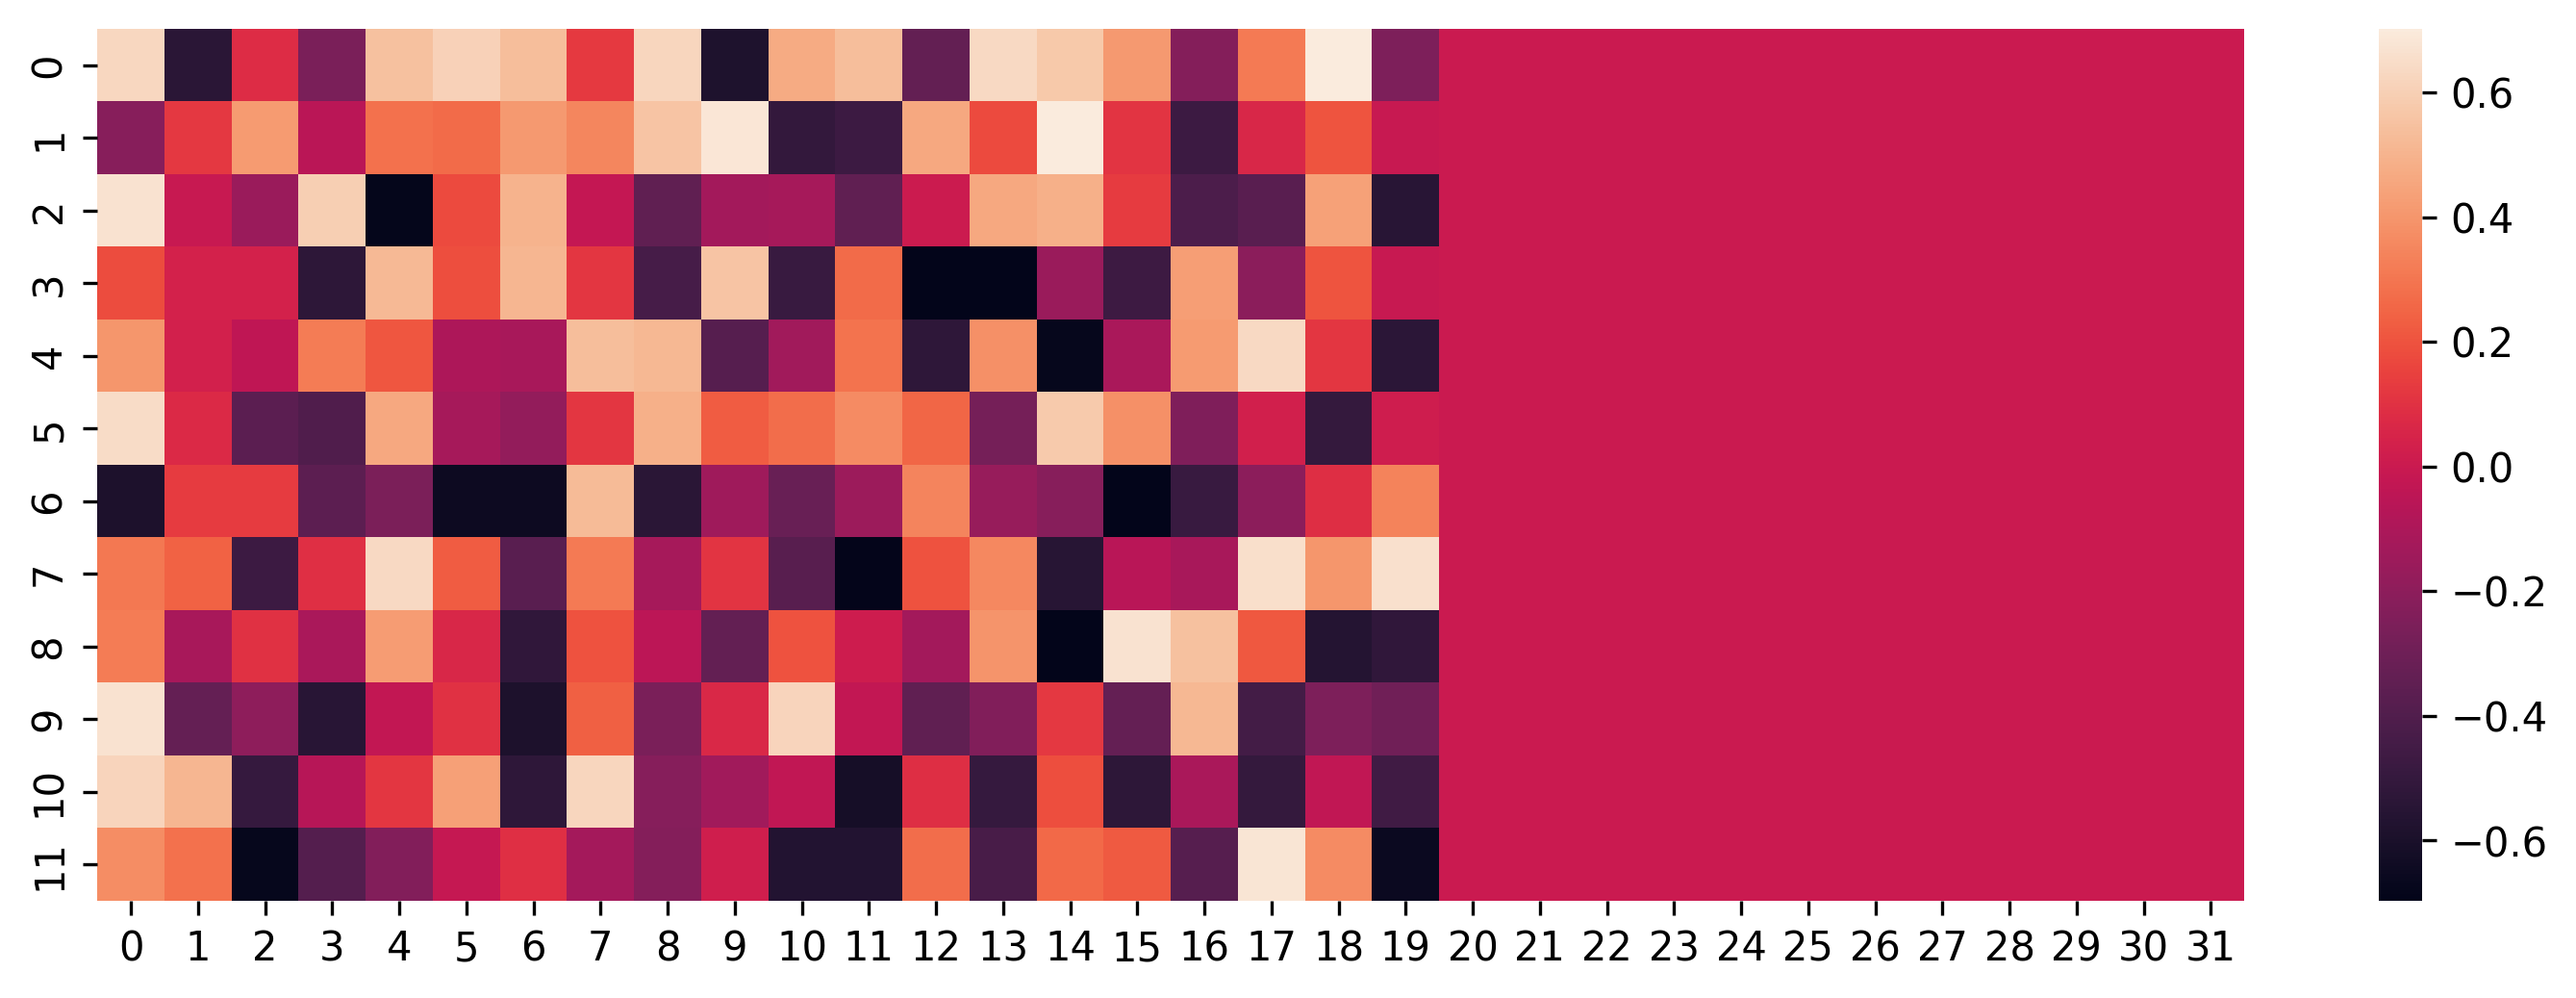

In [8]:
ax = sns.heatmap(mod_se2[0].weight)
plt.show()

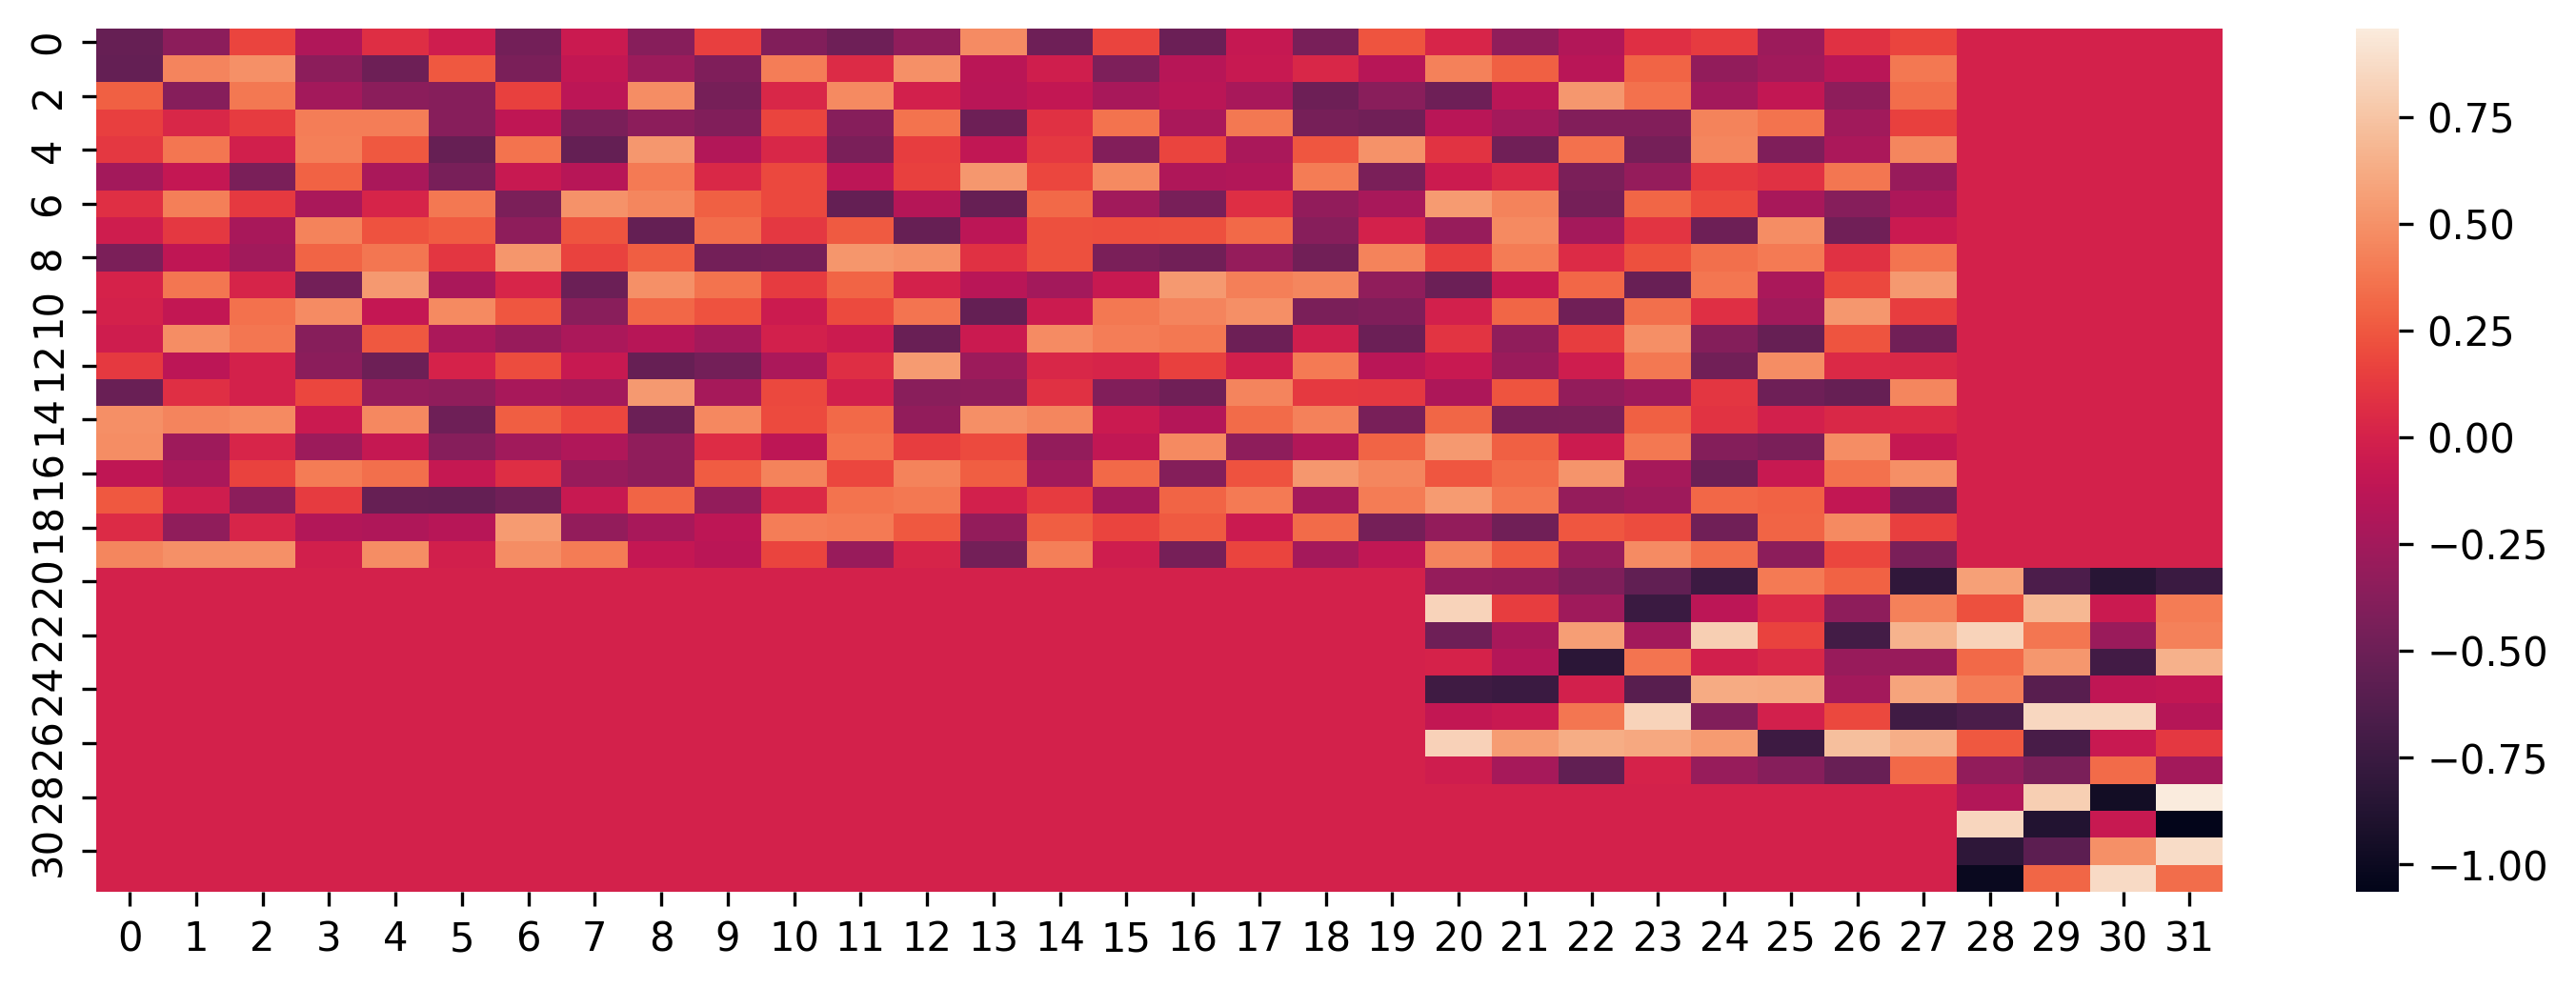

In [9]:
ax = sns.heatmap(mod_se2[1].w_rec)


In [10]:
spec = mapper(modFFwd.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__11309235984_transformed_SE_11380669888" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[ 0.62909236, -0.53928806,  0.08101529, -0.26451297,  0.5447854 ,
          0.60539638,  0.53797604,  0.12400149,  0.62184601, -0.5844131 ,
          0.468305  ,  0.53326373, -0.33875091,  0.63316015,  0.57357732,
          0.41188819, -0.22783039,  0.31148108,  0.69797771, -0.25157542,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.2182168 ,  0.11851327,  0.41636366, -0.05249794,  0.28550178,
          0.27069423,  0.40757007,  0.35088282,  0.55763522,  0.68486631,
         -0.51020223, -0.47417399,  0.46021431,  0.17438511,  0.70250411,
          0.11193409, -0.47703159,  0.06312177,  0.20291659, -0.00827235,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [11]:
spec.update(parameter_clustering(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11309235984_transformed_SE_11380669888" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[ 0.62909236, -0.53928806,  0.08101529, -0.26451297,  0.5447854 ,
          0.60539638,  0.53797604,  0.12400149,  0.62184601, -0.5844131 ,
          0.468305  ,  0.53326373, -0.33875091,  0.63316015,  0.57357732,
          0.41188819, -0.22783039,  0.31148108,  0.69797771, -0.25157542,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.2182168 ,  0.11851327,  0.41636366, -0.05249794,  0.28550178,
          0.27069423,  0.40757007,  0.35088282,  0.55763522,  0.68486631,
         -0.51020223, -0.47417399,  0.46021431,  0.17438511,  0.70250411,
          0.11193409, -0.47703159,  0.06312177,  0.20291659, -0.00827235,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [12]:
spec.update(autoencoder_quantization(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11309235984_transformed_SE_11380669888" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[15, 11,  0,  3, 13, 15, 13,  4, 13, 15, 13, 11,  6, 15, 15, 10,
          10,  6, 15,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 6,  0,  9,  0, 10,  2,  6, 13, 15, 15, 11, 14, 13,  1, 15,  8,
          11,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  0,  1, 14, 15,  8, 11,  0,  9,  0,  0, 10,  0, 11, 13,  8,
          13, 10, 13, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 8,  0,  0, 13, 11,  8, 11,  0, 13, 15, 14,  8, 15, 15,  2, 11,
          14,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 7,  0,  0,  2,  2,  2,  1,  7, 14,  9,  4,  6, 13,  3, 15,  2,
           6, 15,  4, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  2,  5, 10, 14,  1,  1,  1, 11,  4,  4, 11,  3,  8,  7, 14,
           4,  0, 11,  0,  0,  0,  0,  0, 

In [13]:
spec.update(config_from_specification(**spec))
spec

{'mapped_graph': GraphHolder "JaxSequential__11309235984_transformed_SE_11380669888" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[15, 11,  0,  3, 13, 15, 13,  4, 13, 15, 13, 11,  6, 15, 15, 10,
          10,  6, 15,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 6,  0,  9,  0, 10,  2,  6, 13, 15, 15, 11, 14, 13,  1, 15,  8,
          11,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  0,  1, 14, 15,  8, 11,  0,  9,  0,  0, 10,  0, 11, 13,  8,
          13, 10, 13, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 8,  0,  0, 13, 11,  8, 11,  0, 13, 15, 14,  8, 15, 15,  2, 11,
          14,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 7,  0,  0,  2,  2,  2,  1,  7, 14,  9,  4,  6, 13,  3, 15,  2,
           6, 15,  4, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  2,  5, 10, 14,  1,  1,  1, 11,  4,  4, 11,  3,  8,  7, 14,
           4,  0, 11,  0,  0,  0,  0,  0, 

In [14]:
mod_se2_reconstructed = dynapsim_from_config(spec['config'])

In [15]:
from rockpool.devices.dynapse.quantization import WeightHandler

In [16]:
mod_se2_reconstructed[0].weight

array([[ 0.64712986, -0.48766598,  0.        , -0.32522554,  0.47783231,
         0.64712986,  0.47783231,  0.15946388,  0.47783231, -0.64712986,
         0.47783231,  0.48766598, -0.32876143,  0.64712986,  0.64712986,
         0.33173799, -0.33173799,  0.32876143,  0.64712986, -0.15946388,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.32876143,  0.        ,  0.31836843, -0.        ,  0.33173799,
         0.16929755,  0.32876143,  0.47783231,  0.64712986,  0.64712986,
        -0.48766598, -0.49120187,  0.47783231,  0.15592799,  0.64712986,
         0.16244044, -0.48766598,  0.        ,  0.16244044, -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.64712986, -0.        , -0.15592799,  0.4912

In [17]:
int_mask = np.array(spec["weights_in"])
sign_mask = np.array(spec["sign_in"])
Iw = np.array([spec["Iw_0"], spec["Iw_1"], spec["Iw_2"], spec["Iw_3"]]).T
w_in_q = WeightHandler.restore_weight_matrix(n_bits=4, code=Iw, int_mask=int_mask, sign_mask=sign_mask) / mod_se2_reconstructed[1].Iscale

In [18]:
mod_se2_reconstructed[0].weight

array([[ 0.64712986, -0.48766598,  0.        , -0.32522554,  0.47783231,
         0.64712986,  0.47783231,  0.15946388,  0.47783231, -0.64712986,
         0.47783231,  0.48766598, -0.32876143,  0.64712986,  0.64712986,
         0.33173799, -0.33173799,  0.32876143,  0.64712986, -0.15946388,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.32876143,  0.        ,  0.31836843, -0.        ,  0.33173799,
         0.16929755,  0.32876143,  0.47783231,  0.64712986,  0.64712986,
        -0.48766598, -0.49120187,  0.47783231,  0.15592799,  0.64712986,
         0.16244044, -0.48766598,  0.        ,  0.16244044, -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.64712986, -0.        , -0.15592799,  0.4912

In [19]:
w_in_q[0]

array([[ 0.64776784, -0.4882307 ,  0.        , -0.32493562,  0.4795248 ,
         0.64776784,  0.4795248 ,  0.15953712,  0.4795248 , -0.64776784,
         0.4795248 ,  0.4882307 , -0.32778022,  0.64776784,  0.64776784,
         0.3315382 , -0.3315382 ,  0.32778022,  0.64776784, -0.15953712,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.32778022,  0.        ,  0.31998762, -0.        ,  0.3315382 ,
         0.16824308,  0.32778022,  0.4795248 ,  0.64776784,  0.64776784,
        -0.4882307 , -0.4910753 ,  0.4795248 ,  0.15669252,  0.64776784,
         0.1632951 , -0.4882307 ,  0.        ,  0.1632951 , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.64776784, -0.        , -0.15669252,  0.4910

### Values are close but not exactly the same!!!

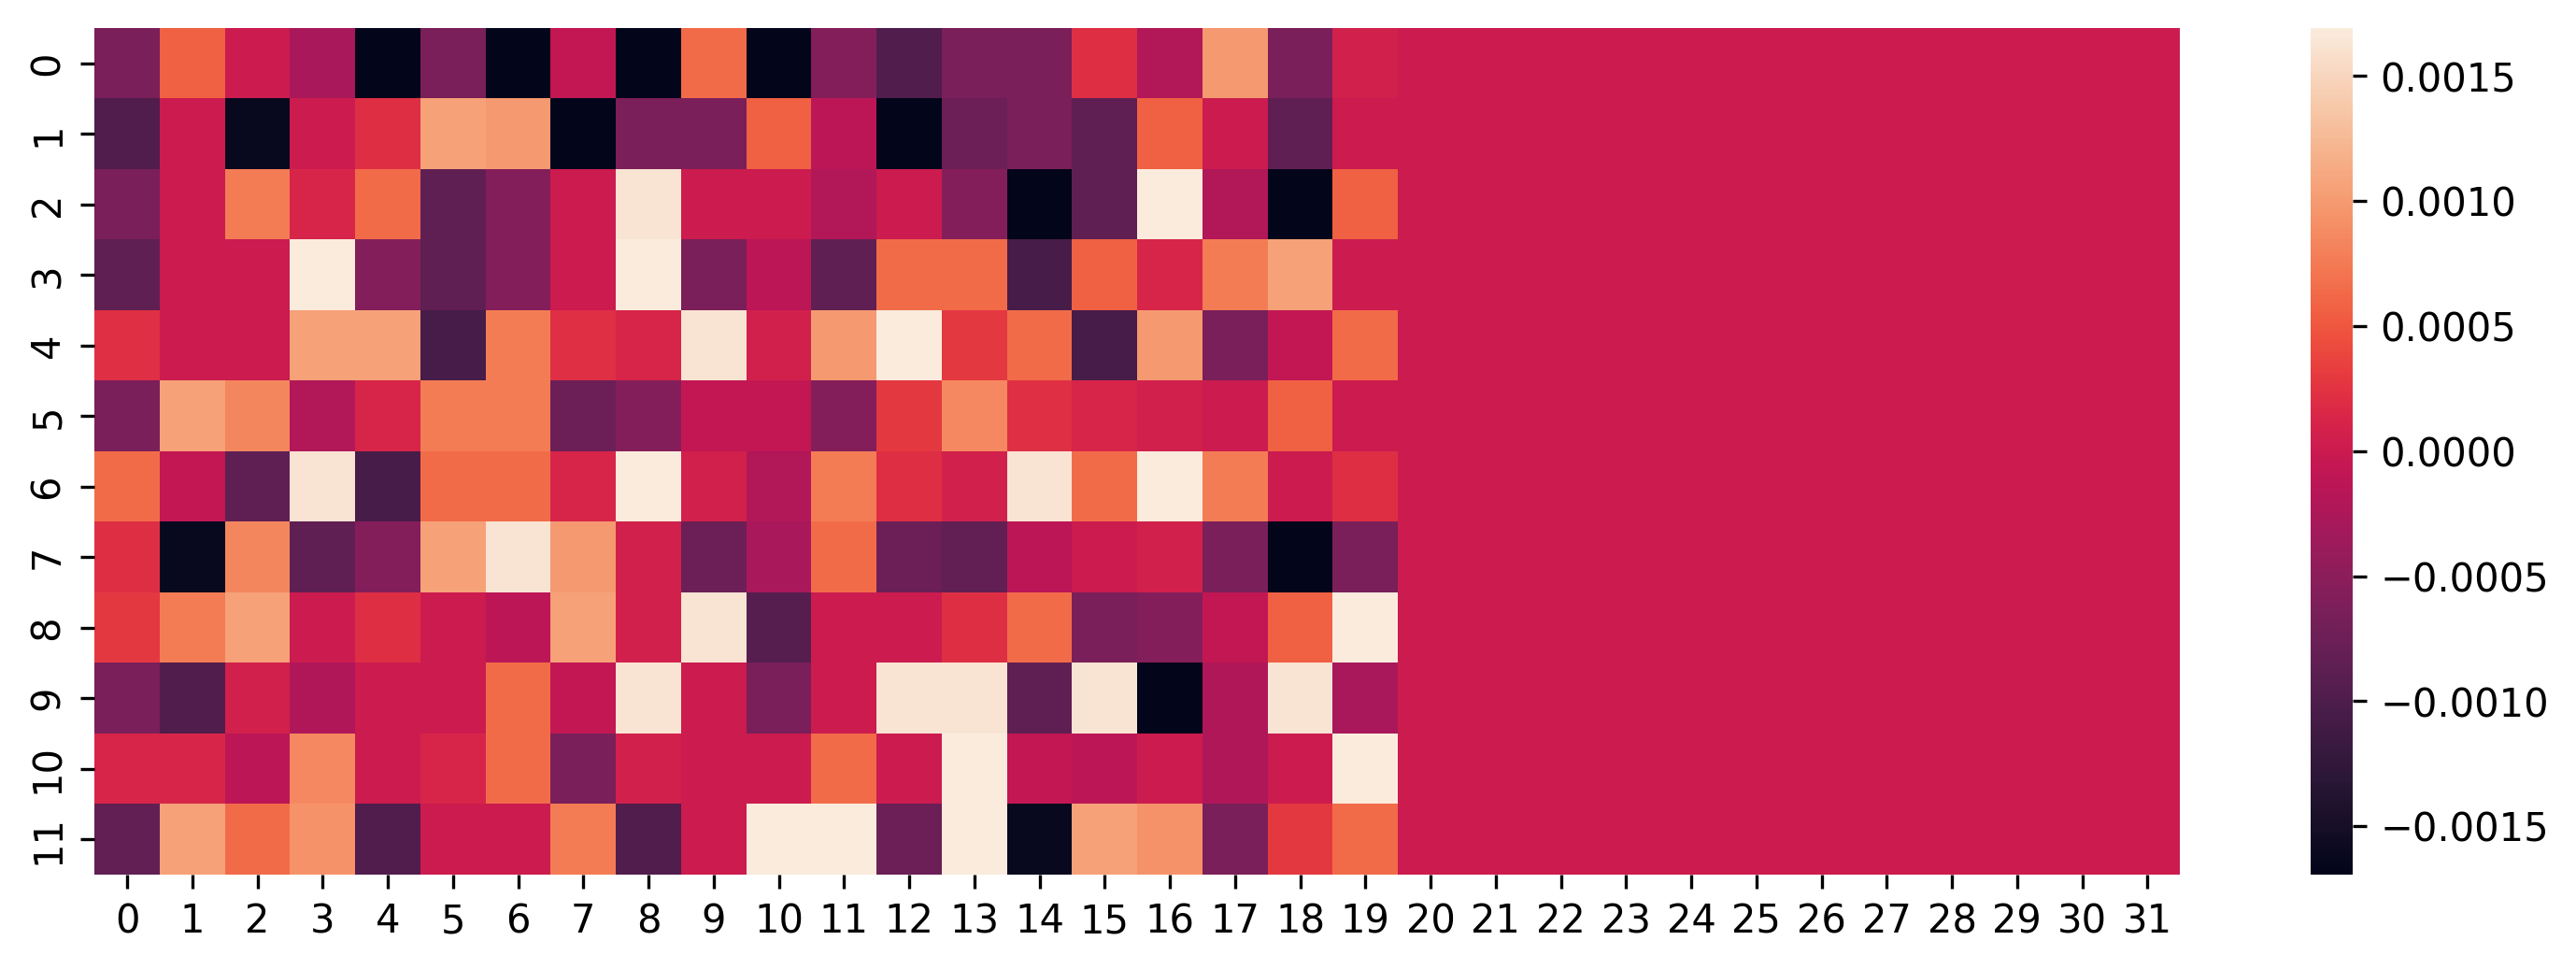

In [20]:
ax = sns.heatmap(mod_se2_reconstructed[0].weight - w_in_q[0])
plt.show()